In [1]:
import pandas
import numpy
import datetime
import os
os.environ["CDF_LIB"] = "cdf36_4-dist/lib"
from spacepy import pycdf
import seaborn as sns
import aacgmv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
outBaseDir = "/home/bharat/Documents/code/scwsaps/data/mag/"
inpDate = datetime.datetime(2011,6,8)
inpDateRng = [ datetime.datetime(2011,6,8,3),\
              datetime.datetime(2011,6,8,7) ]
# [ datetime.datetime(2011,5,16,7),\
#               datetime.datetime(2011,5,16,10) ]
# goodStnList = [ "GJOA", "RANK", "INUV", "KAKO", "SNAP",\
#                "BRW", "FCC", "EAGL", "GILL", "UKIA", "PINA" ]
goodStnList = [ "PTRS", "PGEO", "WHIT", "HOMR", "TPAS",\
               "PINA", "FYTS", "PINE" ]

In [3]:
# read station data
# read_csv can't handle this!
stnCodeArr = []
stnNameArr = []
stnMlatArr = []
stnMlonArr = []
fStn = open(outBaseDir + "Station-Code-19700101.txt")
for nl, ll in enumerate(fStn.readlines()):
    if nl > 0:
        lineData = ll.split()
        stnCodeArr.append( lineData[0] )
        stnNameArr.append( lineData[3] )
        stnMlatArr.append( float(lineData[-5]) )
        stnMlonArr.append( float(lineData[-4]) )
# convert to dataframe
thmStnDF = pandas.DataFrame( {
    "station":stnCodeArr,
    "name":stnNameArr,
    "mlat":stnMlatArr,
    "mlon":stnMlonArr
} )
thmStnDF.head()

,mlat,mlon,name,station
0,65.49,101.09,"Abisko,",ABK
1,68.75,52.69,"Tasiilaq,",AMK
2,65.67,136.68,"Amderma,",AMD
3,48.79,331.29,"Americus,",AMER
4,66.60,99.44,"Andenes,",AND


In [4]:
thmFrames = []
thmDir = outBaseDir + "thg_" + inpDate.strftime("%Y%m%d")
for subdir, dirs, files in os.walk(thmDir):
    for currFile in files:
        currStn = currFile.split("_")[3]
#         print subdir, currFile
        currCdf = pycdf.CDF(subdir + "/" + currFile)
        # convert epoch to datetime
        varNameStarts = 'thg_mag_' + currStn
        dtList = numpy.array( [ datetime.datetime.utcfromtimestamp(e)\
                  for e in currCdf[varNameStarts + '_time'][...] ] )
        # get each magn.fld components
        hCompList = currCdf[varNameStarts][...][:,0]
        dCompList = currCdf[varNameStarts][...][:,1]
        zCompList = currCdf[varNameStarts][...][:,2]
        currThmDF = pandas.DataFrame( { 
                    "date" : dtList,
                    "H" : hCompList,
                    "D" : dCompList,
                    "Z" : dCompList
                } )
        currThmDF["station"] = currStn.upper()
        thmFrames.append( currThmDF )
        
thmDataDF = pandas.concat( thmFrames )
thmDataDF.head()

,D,H,Z,date,station
0,-6.97,15023.580078,-6.97,2011-06-08 00:00:01.000,NAIN
1,-7.00,15023.650391,-7.00,2011-06-08 00:00:01.500,NAIN
2,-6.95,15023.730469,-6.95,2011-06-08 00:00:02.000,NAIN
3,-7.03,15023.849609,-7.03,2011-06-08 00:00:02.500,NAIN
4,-7.05,15023.830078,-7.05,2011-06-08 00:00:03.000,NAIN


In [5]:
selList = [ "KIAN", "MCGR", "UKIA", "LOYS", "GBAY" ]
selThmsStns = thmStnDF[ ((thmStnDF["mlon"] >= 250.) |\
                (thmStnDF["mlon"] <= 25.) ) &\
                (thmStnDF["mlat"] >= 50.) \
                ].reset_index(drop=True)
# get only those stations that have values
dataStnList = thmDataDF["station"].unique()
selThmsStns = selThmsStns[ selThmsStns["station"].isin(dataStnList) ]
selThmsStns = selThmsStns[ selThmsStns["station"].isin(goodStnList) ]
# sort by latitude and longitude
selThmsStns = selThmsStns.sort_values(by=["mlat", "mlon"], ascending=False)
print selThmsStns

     mlat    mlon         name station
57  63.64  279.62  Whitehorse,    WHIT
54  63.12  324.23          The    TPAS
40  59.96  331.87      Pinawa,    PINA
43  59.90  283.97  Petersburg,    PTRS
39  59.07  296.09       Prince    PGEO
41  52.15  323.63         Pine    PINE


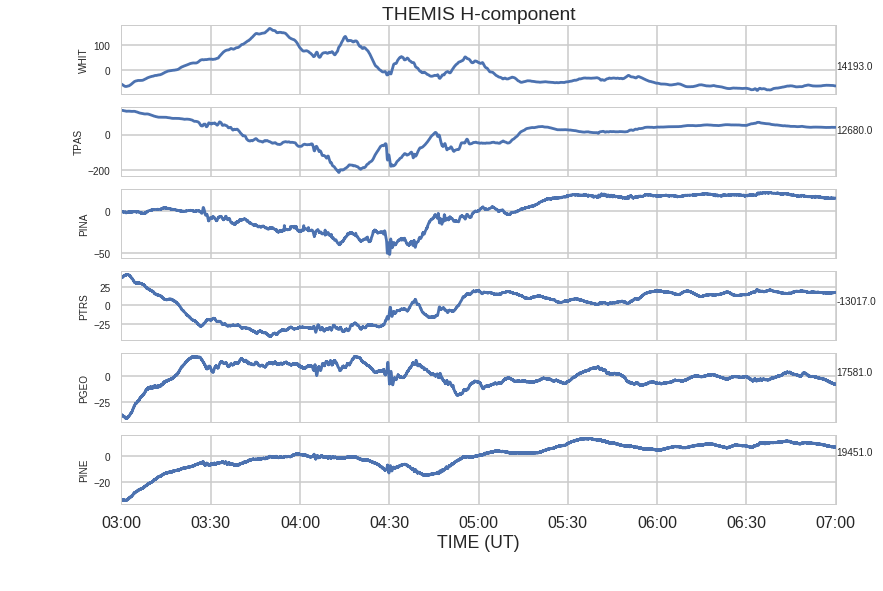

In [6]:
# plot the data
sns.set_style("whitegrid")
sns.set_context("poster")
pltMagcomp = "H"
# some stations are selected
# select only those stations which are in our list
finStations = list(selThmsStns["station"].values)
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(len(finStations), sharex=True)
for ind,stn in enumerate(finStations):
    currStnDF = thmDataDF[ (thmDataDF["station"] == stn) &\
                    (thmDataDF["date"] >= inpDateRng[0] ) &\
                    (thmDataDF["date"] <= inpDateRng[1] ) ]
    pltMagcomp = "H"
    meanMagFld = currStnDF[pltMagcomp].mean()
    # Plot values
    pltYData = currStnDF[pltMagcomp].values-meanMagFld
    axArr[ind].plot(currStnDF["date"].values, pltYData)
#     axArr[ind].text(0.8, 0.9, str(meanMagFld), size='small')
    axArr[ind].annotate(str(round(meanMagFld)), (date2num(inpDateRng[1]), pltYData.mean()), xytext=(1, 1), 
            textcoords='offset points',fontsize=10)
    # set X-axis formatter and limit
    axArr[ind].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
    axArr[ind].set_xlim( [inpDateRng[0], inpDateRng[1]] )
    axArr[ind].set_ylabel( stn, fontsize=10 )
    # set y-axis font size
    axArr[ind].yaxis.set_tick_params(labelsize=10)
        
        
axArr[-1].set_xlabel("TIME (UT)")
axArr[0].set_title("THEMIS " + pltMagcomp + "-component")
f.savefig( "../plots/thm-" + pltMagcomp + "-comp" + ".pdf",bbox_inches='tight' )

In [7]:
# selThmsStns = thmStnDF[ ((thmStnDF["mlon"] >= 250.) |\
#                 (thmStnDF["mlon"] <= 25.) ) &\
#                 (thmStnDF["mlat"] >= 60.) \
#                 ].reset_index(drop=True)
# # get only those stations that have values
# dataStnList = thmDataDF["station"].unique()
# selThmsStns = selThmsStns[ selThmsStns["station"].isin(dataStnList) ]
# selThmsStns = selThmsStns[ selThmsStns["station"].isin(goodStnList) ]
# # sort by latitude and longitude
# selThmsStns = selThmsStns.sort_values(by=["mlon", "mlat"], ascending=False)
# print selThmsStns

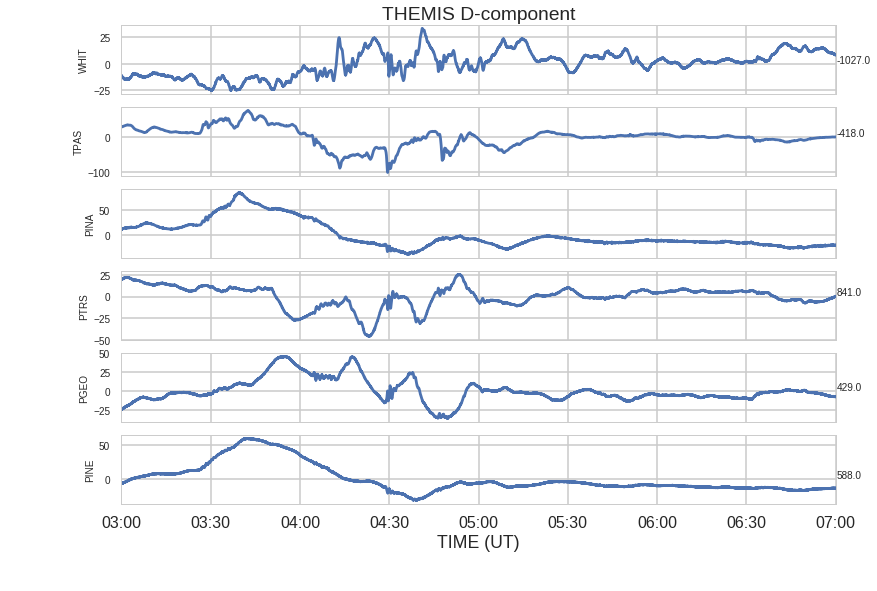

In [8]:
# plot the data
sns.set_style("whitegrid")
sns.set_context("poster")
pltMagcomp = "D"
# some stations are selected
# select only those stations which are in our list
finStations = list(selThmsStns["station"].values)
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(len(finStations), sharex=True)
for ind,stn in enumerate(finStations):
    currStnDF = thmDataDF[ (thmDataDF["station"] == stn) &\
                    (thmDataDF["date"] >= inpDateRng[0] ) &\
                    (thmDataDF["date"] <= inpDateRng[1] ) ]
    meanMagFld = currStnDF[pltMagcomp].mean()
    # Plot values
    pltYData = currStnDF[pltMagcomp].values-meanMagFld
    axArr[ind].plot(currStnDF["date"].values, pltYData)
#     axArr[ind].text(0.8, 0.9, str(meanMagFld), size='small')
    axArr[ind].annotate(str(round(meanMagFld)), (date2num(inpDateRng[1]), pltYData.mean()), xytext=(1, 1), 
            textcoords='offset points',fontsize=10)
    # set X-axis formatter and limit
    axArr[ind].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
    axArr[ind].set_xlim( [inpDateRng[0], inpDateRng[1]] )
    axArr[ind].set_ylabel( stn, fontsize=10 )
    # set y-axis font size
    axArr[ind].yaxis.set_tick_params(labelsize=10)
        
        
axArr[-1].set_xlabel("TIME (UT)")
axArr[0].set_title("THEMIS " + pltMagcomp + "-component")
f.savefig( "../plots/thm-" + pltMagcomp + "-comp" + ".pdf",bbox_inches='tight' )